<a href="https://colab.research.google.com/github/kahhotan/Time-Series/blob/main/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VIX Time Series

Loading Libraries

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot

%matplotlib inline

Load Data

In [ ]:
#Load dataframe
df = pd.read_csv("vix.csv", index_col = 'Date', parse_dates = True)

Data Exploration and Preprocessing

In [ ]:
#Data exploration
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-02-01,17.240000,17.240000,17.240000,17.240000,17.240000,0
1990-03-01,18.190001,18.190001,18.190001,18.190001,18.190001,0
1990-04-01,19.219999,19.219999,19.219999,19.219999,19.219999,0
1990-05-01,20.110001,20.110001,20.110001,20.110001,20.110001,0
1990-08-01,20.260000,20.260000,20.260000,20.260000,20.260000,0


In [ ]:
df = df.rename(columns = {'Adj Close' : 'AdjClose'})

In [ ]:
#select only AdjClose, create new dataframe
df = df[["AdjClose"]].copy()

In [ ]:
#Set frequency to daily

df.index = df.index.to_period ('D')

In [ ]:
df.head()

,AdjClose
Date,
1990-02-01,17.240000
1990-03-01,18.190001
1990-04-01,19.219999
1990-05-01,20.110001
1990-08-01,20.260000


In [ ]:
vix.tail()

,AdjClose
Date,
2021-06-28,15.76
2021-06-29,16.02
2021-06-30,15.83
2021-01-07,15.48
2021-02-07,15.07


In [ ]:
vix.describe()

,AdjClose
count,7938.000000
mean,19.489588
std,8.065831
min,9.140000
25%,13.720000
50%,17.540001
75%,22.870001
max,82.690002


In [ ]:
type(vix)

pandas.core.frame.DataFrame

In [ ]:
#Converting to time series

vix_ts = vix.values

In [ ]:
type(vix_ts)

numpy.ndarray

<AxesSubplot:xlabel='Date'>

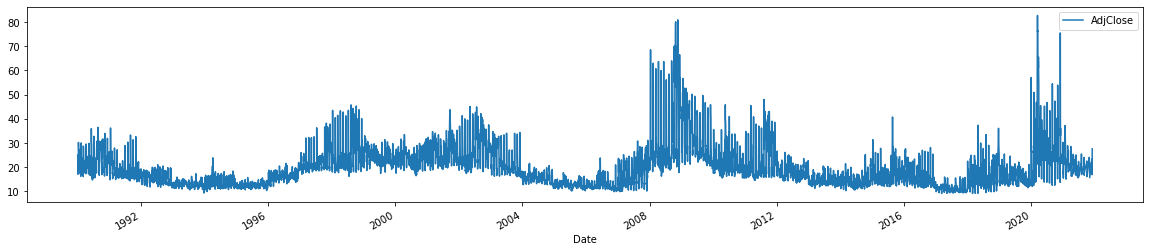

In [ ]:
vix.plot(figsize = (20,4))

In [ ]:
#Moving average smoothing??

vix_rolling = vix.rolling(window = 200).mean()

<AxesSubplot:xlabel='Date'>

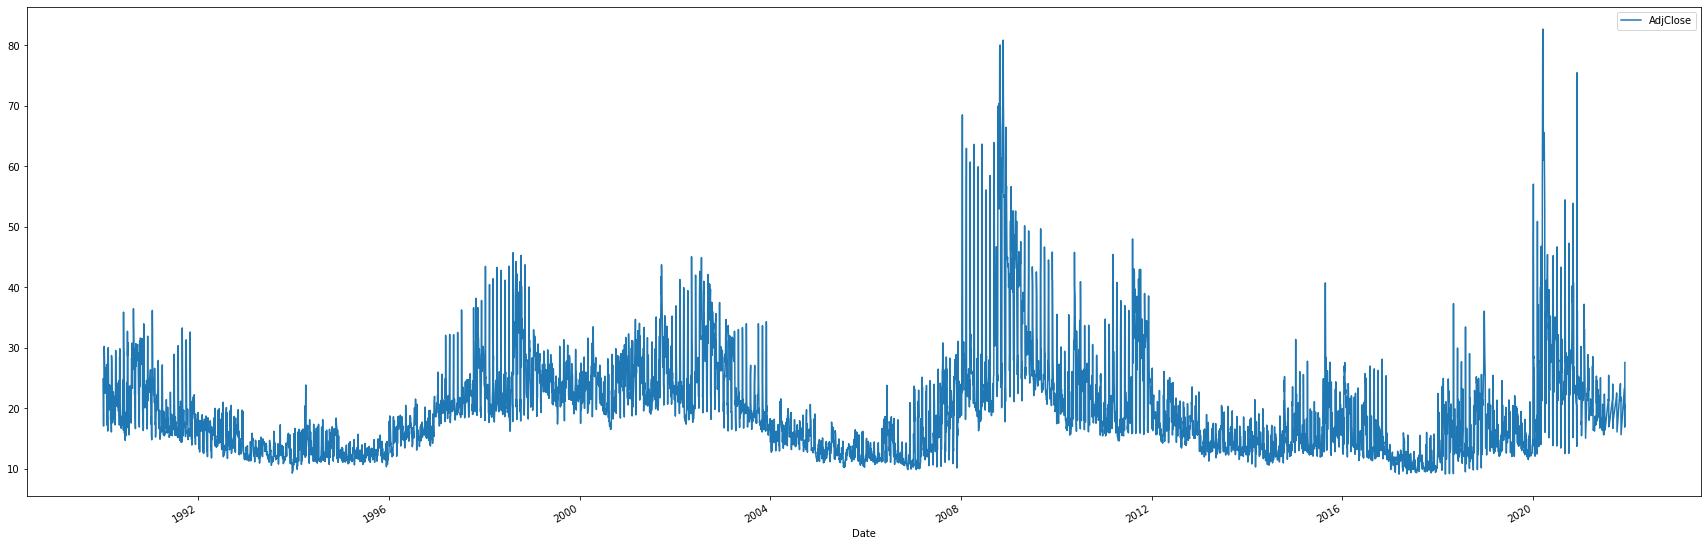

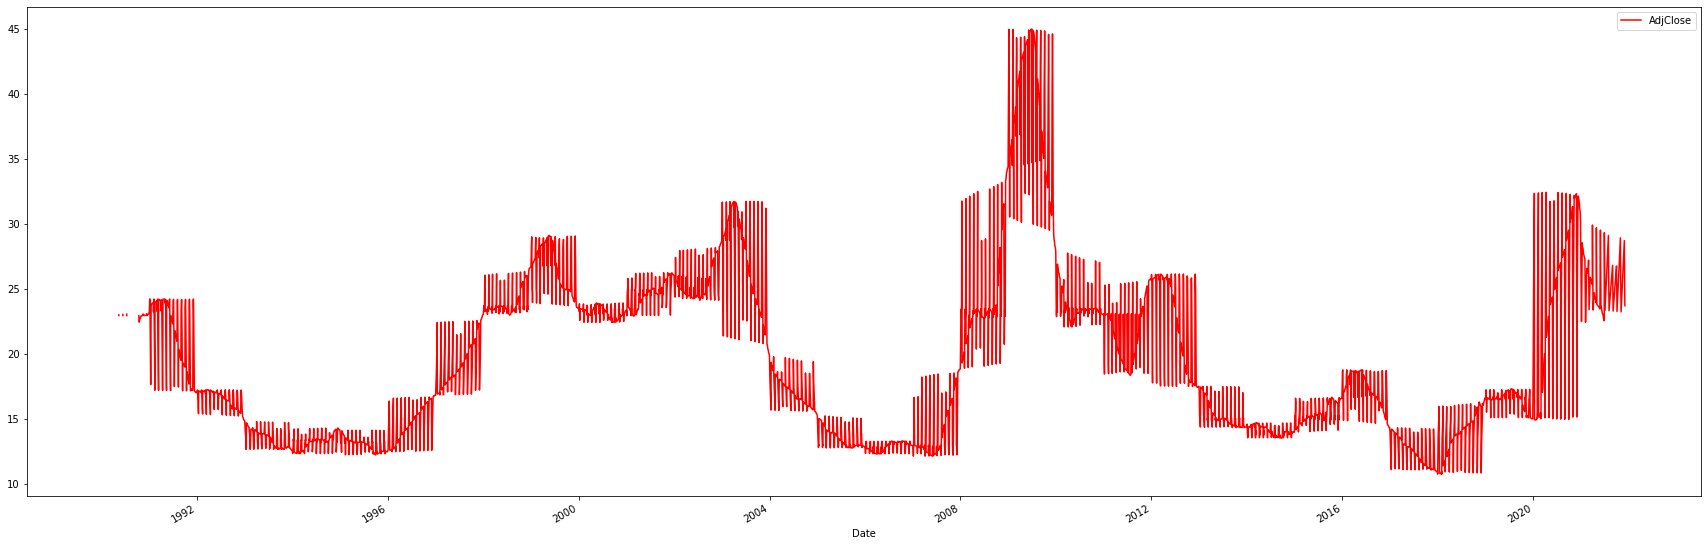

In [ ]:
vix.plot(figsize = (30,10))
vix_rolling.plot(figsize = (30,10), color = 'red')

In [ ]:
#Statistical stationary Test

vix_adf = adfuller(vix['AdjClose'])

In [ ]:
#Null: It is non stationary
#Alt: It is stationary

def adfuller_test(AdjClose):
    result = adfuller(AdjClose)
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Reject the null hypothesis. Time Series has no unit root and is stationary")
    else:
        print("Time series has a unit root, indicating it is non-stationary ")
        
adfuller_test(vix['AdjClose'])


ADF Test Statistic : -6.541278061814483
p-value : 9.333402186476175e-09
Number of Lags Used : 10
Number of Observations Used : 7927
Reject the null hypothesis. Time Series has no unit root and is stationary


Establishing Baseline Model

In [ ]:
#Persistence Algorithm (Naive forecast)

baseline = pd.DataFrame(vix_ts) #created 'baseline' as 'df_ts'(numpy.ndarray type) does not contain 'shift' function

In [ ]:
#Create laggard dataset (t+1)

vix_laggard = pd.concat([baseline, baseline.shift(1)], axis = 1)

In [ ]:
vix_laggard.head()

,0,0
0,17.240000,NaN
1,18.190001,17.240000
2,19.219999,18.190001
3,20.110001,19.219999
4,20.260000,20.110001


In [ ]:
vix_laggard.columns = ['Actual', 'Lag']

In [ ]:
vix_laggard.head()

,Actual,Lag
0,17.240000,NaN
1,18.190001,17.240000
2,19.219999,18.190001
3,20.110001,19.219999
4,20.260000,20.110001


In [ ]:
vix_test = vix_laggard[1:]

In [ ]:
vix_test.head()

,Actual,Lag
1,18.190001,17.240000
2,19.219999,18.190001
3,20.110001,19.219999
4,20.260000,20.110001
5,22.200001,20.260000


In [ ]:
vix_test.tail()

,Actual,Lag
7933,15.76,15.62
7934,16.02,15.76
7935,15.83,16.02
7936,15.48,15.83
7937,15.07,15.48


In [ ]:
vix_mse = mean_squared_error(vix_test.Actual, vix_test.Lag)

In [ ]:
vix_mse

2.7116879471469835

In [ ]:
np.sqrt(vix_mse)

1.6467203609438317

ARIMA (p,d,q) Model

In [ ]:
#Stationary Test

test_result=adfuller(vix['AdjClose'])

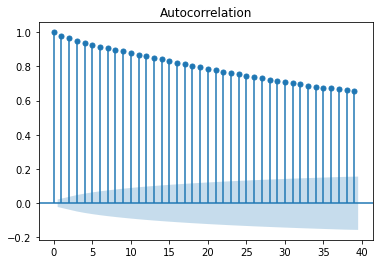

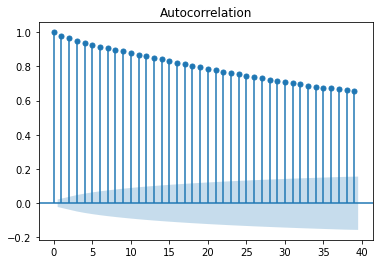

In [ ]:
#Autocorrelation
#plot acf is to identify parameter q

plot_acf(vix)

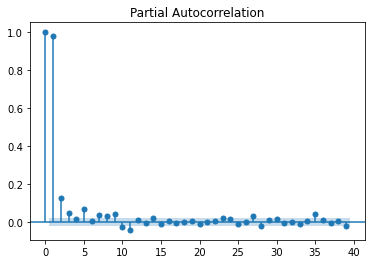

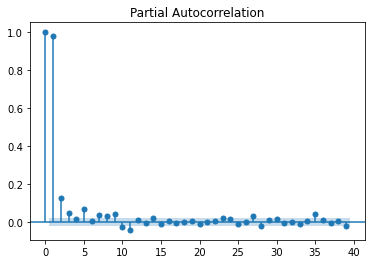

In [ ]:
#Partial Autocorrelation
plot_pacf(vix)

In [ ]:
#Splitting into test and training set

vix.size

7938

In [ ]:
vix_train = vix[0:5500]
vix_test = vix[5500:7938]

In [ ]:
vix_train.size

5500

In [ ]:
vix_test.size

2438

In [ ]:
vix_arima = ARIMA (vix_train, order = (4,0,2))

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'


In [ ]:
vix_arima_fit = vix_arima.fit()

In [ ]:
vix_arima_fit.aic

20331.24115457311

In [ ]:
vix_forecast = vix_arima_fit.forecast(steps = 2438)[0]

In [ ]:
vix_forecast

array([29.63614986, 29.86349159, 29.94762866, ..., 20.68216464,
       20.68216464, 20.68216464])

In [ ]:
vix_test

,AdjClose
Date,
2011-10-25,32.220001
2011-10-26,29.860001
2011-10-27,25.459999
2011-10-28,24.530001
2011-10-31,29.959999
...,...
2021-06-28,15.760000
2021-06-29,16.020000
2021-06-30,15.830000


In [ ]:
np.sqrt(mean_squared_error(vix_test, vix_forecast))

8.027950330909887